In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import dask
import cartopy.crs as ccrs
from dask.diagnostics import ProgressBar
from itertools import product
from joblib import Parallel, delayed
from collections import defaultdict

import common
import vcm
import fv3viz

In [2]:
plt.style.use("tableau-colorblind10")

In [3]:
base = "zc-emu-monthly-normfix-m{init}-seed3-30d-v1-{run_type}"
run_types = ["online", "offline"]
inits = [f"{i:02d}" for i in range(1, 13)]

In [4]:
dt = 900 # s
seconds_per_day = 60 * 60 * 24  # seconds/min * min/hr * hr/day
m_to_mm = 1000

# from physcons.f
cp = 1.0046e3 # J / (kg K)
gravity = 9.80665 # m / s^2
lv = 2.5e6  # J / kg water
rho_water = 1000.0 # kg / m^3

In [5]:
diag_key = "surface_precipitation_due_to_zhao_carr_emulator"
wrapper_key = "total_precipitation"

In [6]:
def kg_m2_s_to_mm_day(da):
    return da * seconds_per_day / rho_water * m_to_mm

def m_to_mm_day(da):
    return da / dt * m_to_mm * seconds_per_day


This confirms total precip is from the wrapper.  Includes Zhao-Carr precip and convective precipitation.  Useful for whether we are still at the correct climatology.

In [7]:
@common.memoize_xarray_out
def get_pr_zonal_and_hist(group):
    data = common.open_group(group)
    emu_key =  "surface_precipitation_due_to_zhao_carr_emulator"
    fort_key =  "surface_precipitation_due_to_zhao_carr_physics"
    pr = kg_m2_s_to_mm_day(data[[emu_key, fort_key]])
    pr["total_precipitation"] = m_to_mm_day(data["total_precipitation"])


    bin_edges = np.logspace(-3, 2.5, 50)
    counts_emu, _ = dask.array.histogram(pr[emu_key], bins=bin_edges)
    counts_fort, _ = dask.array.histogram(pr[fort_key], bins=bin_edges)

    zonal = vcm.zonal_average_approximate(data.lat, pr)

    return xr.Dataset(
        {
            "emulator": xr.DataArray(data=counts_emu, dims="bins").load(),
            "fortran": xr.DataArray(data=counts_fort, dims="bins").load(),                                 
        },
        coords = {"bin_edges": ("bin_edges", bin_edges)}
    ).merge(zonal.load())

In [8]:
groups = [base.format(init=init, run_type=run_type) for init, run_type in product(inits, run_types)]
args = list(product(inits, run_types))

In [11]:
jobs = [delayed(get_pr_zonal_and_hist)(g) for g in groups]
results = Parallel(n_jobs=12)(jobs)

In [12]:
def gather(groups, results):
    out = defaultdict(list)
    for g, res in zip(groups, results):
        if "offline" in g:
            out["offline"].append(res)
        else:
            out["online"].append(res)

    offline = xr.concat(out["offline"], dim="init")
    online = xr.concat(out["online"], dim="init")

    return offline, online


In [13]:
offline_pr, online_pr = gather(groups, results)

## Zonal Precipitation

Total precip from wrapper

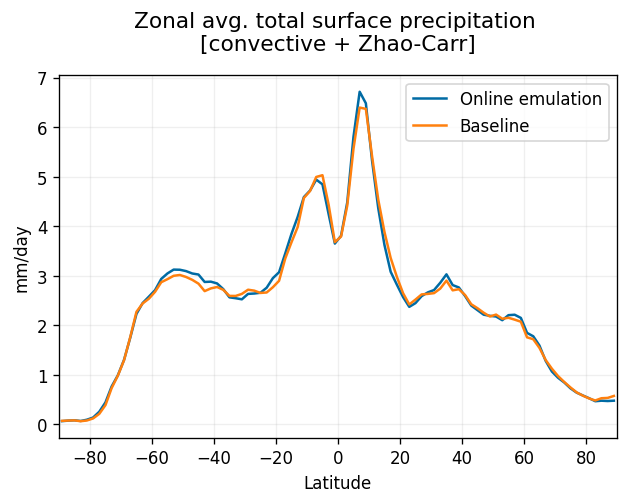

In [12]:
plt.figure(dpi=120)
online_pr["total_precipitation"].mean(dim=["init", "time"]).plot(label="Online emulation")
offline_pr["total_precipitation"].mean(dim=["init", "time"]).plot(label="Baseline")
plt.title("Zonal avg. total surface precipitation \n[convective + Zhao-Carr]", size=13, pad=15)
plt.xlabel("Latitude")
plt.ylabel("mm/day")
plt.legend()
plt.xlim(-90, 90)
plt.grid(alpha=0.2)
common.savefig("zonal_precip_total")
plt.show()

Online ZC precip vs the piggy-backed diagnostic

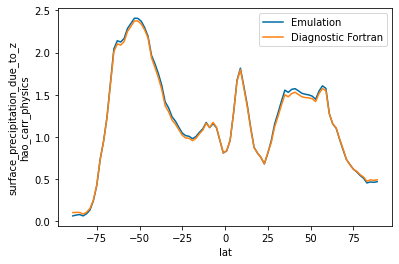

In [17]:
online_pr["surface_precipitation_due_to_zhao_carr_emulator"].mean(dim=["init", "time"]).plot(label="Emulation")
online_pr["surface_precipitation_due_to_zhao_carr_physics"].mean(dim=["init", "time"]).plot(label="Diagnostic Fortran")
plt.legend()
plt.show()

## Calculate some global mean metrics

In [14]:
@common.memoize_xarray_out
def get_pr_mse_bias_v2(group):
    data = common.open_group(group)
    emulator = data["surface_precipitation_due_to_zhao_carr_emulator"]
    target = data["surface_precipitation_due_to_zhao_carr_physics"]

    mse = (emulator - target)**2
    mse_avg = vcm.weighted_average(mse, data.area, dims=["tile", "x", "y"])
    pr_avg = vcm.weighted_average(emulator, data.area, dims=["tile", "x", "y"])
    fort_avg = vcm.weighted_average(target, data.area, dims=["tile", "x", "y"])

    return xr.Dataset(
        data_vars={
            "mse": mse_avg.load(),
            "emulator_mean": pr_avg.load(),
            "fortran_mean": fort_avg.load(),
        }
    )

In [15]:
jobs = [delayed(get_pr_mse_bias_v2)(g) for g in groups]
results = Parallel(n_jobs=12)(jobs)

In [16]:
offline_metrics, online_metrics = gather(groups, results)

In [17]:
offline_metrics

<xarray.Dataset>
Dimensions:        (time: 2872, init: 12)
Coordinates:
  * time           (time) object 2016-01-31 03:00:00 ... 2017-01-30 00:00:00
Dimensions without coordinates: init
Data variables:
    mse            (init, time) float32 5.734e-12 5.207e-12 ... 6.944e-12
    emulator_mean  (init, time) float32 1.603e-05 1.645e-05 ... 1.597e-05
    fortran_mean   (init, time) float32 1.631e-05 1.674e-05 ... 1.63e-05

In [18]:
online_zc_pr_bias = kg_m2_s_to_mm_day(online_metrics['emulator_mean'] - offline_metrics['fortran_mean']).mean()
online_zc_pr_diag_bias = kg_m2_s_to_mm_day(online_metrics['fortran_mean'] - offline_metrics['fortran_mean']).mean()

In [19]:
print(f"Offline RMSE: {kg_m2_s_to_mm_day(np.sqrt(offline_metrics['mse'].mean()).values):1.2f} mm/day")
print(f"Online RMSE: {kg_m2_s_to_mm_day(np.sqrt(online_metrics['mse'].mean()).values):1.2f} mm/day")
print(f"Online bias: {online_zc_pr_bias.values:1.2e} mm/day")
print(f"Online diag bias: {online_zc_pr_diag_bias.values:1.2e} mm/day")

Offline RMSE: 0.22 mm/day
Online RMSE: 0.89 mm/day
Online bias: -2.23e-02 mm/day
Online diag bias: -3.99e-02 mm/day


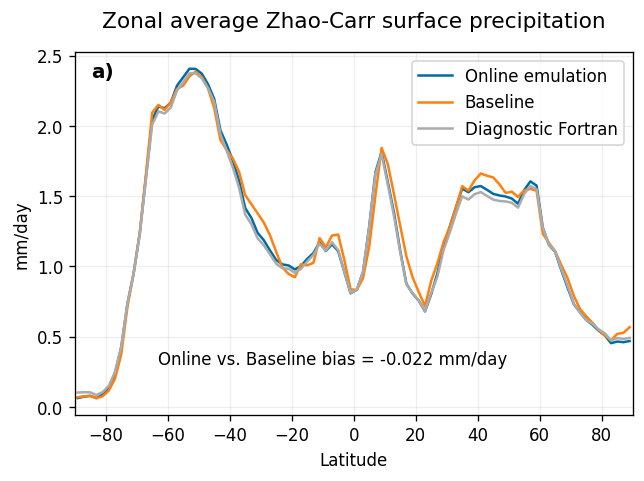

In [25]:
fig, ax = plt.subplots(dpi=120)
online_pr["surface_precipitation_due_to_zhao_carr_emulator"].mean(dim=["init", "time"]).plot(label="Online emulation")
offline_pr["surface_precipitation_due_to_zhao_carr_physics"].mean(dim=["init", "time"]).plot(label="Baseline")
online_pr["surface_precipitation_due_to_zhao_carr_physics"].mean(dim=["init", "time"]).plot(label="Diagnostic Fortran")
plt.ylabel("mm/day")
plt.xlabel("Latitude")
plt.xlim(-90,90)
plt.title("Zonal average Zhao-Carr surface precipitation", size=13, pad=15)
plt.legend()
plt.grid(alpha=0.2)
ax.text(0.03, 0.93, "a)", fontdict=dict(size=12, weight="bold"), transform=ax.transAxes)
ax.text(0.15, 0.14, f"Online vs. Baseline bias = {online_zc_pr_bias.values:.3f} mm/day", transform=ax.transAxes)
common.savefig("zonal_precip_zc")
plt.show()

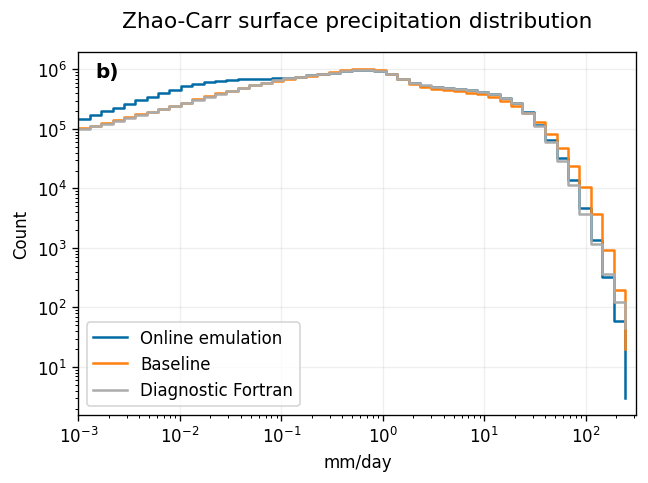

In [45]:
fig, ax = plt.subplots(dpi=120)
bins = online_pr["bin_edges"].values
count_emu = online_pr["emulator"].sum(dim="init").values
count_diag_fort = online_pr["fortran"].sum(dim="init").values
count_fort = offline_pr["fortran"].sum(dim="init").values
plt.step(bins[:-1], count_emu, where="post", label="Online emulation")
plt.step(bins[:-1], count_fort, where="post", label="Baseline")
plt.step(bins[:-1], count_diag_fort, where="post", label="Diagnostic Fortran")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(bins[0], bins[-1])
plt.legend()
ax.text(0.03, 0.93, "b)", fontdict=dict(size=12, weight="bold"), transform=ax.transAxes)
plt.xlabel("mm/day")
plt.ylabel("Count")
plt.title("Zhao-Carr surface precipitation distribution", size=13, pad=15)
plt.grid(alpha=0.2)
common.savefig("zc_precip_distribution")
plt.show()